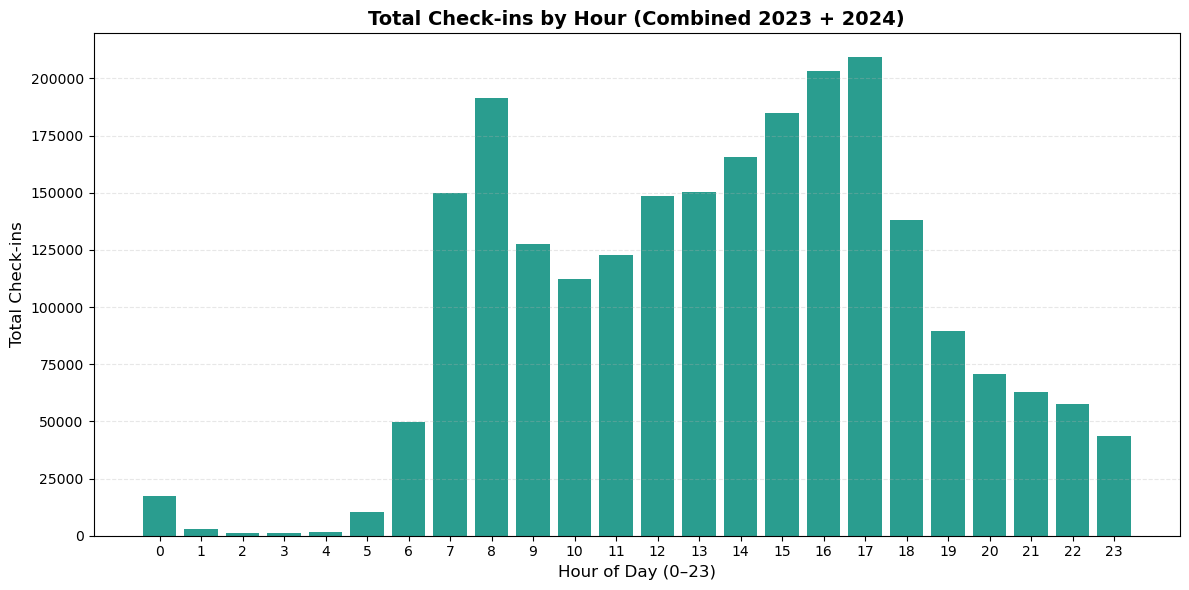

STATISTICAL SIGNIFICANCE TEST: Peak vs Off-Peak Hours
Peak hours defined as: [7, 8, 16, 17, 18]

Average check-ins during PEAK hours: 243.99
Average check-ins during OFF-PEAK hours: 102.26
Difference (Peak - Off-Peak): 141.74

--- Independent Samples t-test ---
t-statistic: 78.0240
p-value: 0.0000e+00
Result: SIGNIFICANT at α=0.05

--- Mann-Whitney U test (non-parametric) ---
U-statistic: 41679474.0000
p-value: 0.0000e+00
Result: SIGNIFICANT at α=0.05

--- Chi-squared test (categorical) ---
Chi-squared statistic: 2847.5260
p-value: 0.0000e+00
Degrees of freedom: 2
Result: SIGNIFICANT at α=0.05


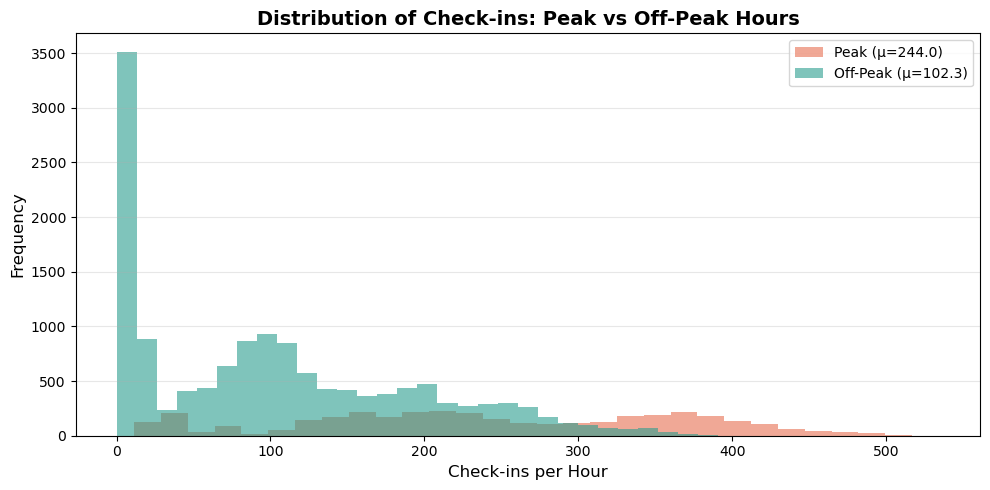

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats

df23 = pd.read_csv(r"C:\Users\inika\OneDrive\Έγγραφα\MSc TIL\Y1\TIL6022\Instappers_per_uur_export_2023.csv")
df24 = pd.read_csv(r"C:\Users\inika\OneDrive\Έγγραφα\MSc TIL\Y1\TIL6022\Instappers_per_uur_export_V3_2024.csv") 

df23["Datum"] = pd.to_datetime(df23["Datum"], format="%d/%m/%Y")
df24["Datum"] = pd.to_datetime(df24["Datum"], format="%d-%m-%Y")

for df in (df23, df24):
    df["Uur"] = df["Uur"].astype(int)
    df["Aantal_check_ins"] = pd.to_numeric(df["Aantal_check_ins"], errors="coerce")

df = pd.concat([df23, df24], ignore_index=True)

df["weekday"] = df["Datum"].dt.weekday  # 0=Mon, 6=Sun
df["weekday_name"] = df["Datum"].dt.day_name()
df["hour_of_week"] = df["weekday"] * 24 + df["Uur"]  # 0-167


hour_totals = df.groupby("Uur", as_index=False)["Aantal_check_ins"].sum().sort_values("Uur")

fig = px.bar(hour_totals, x="Uur", y="Aantal_check_ins",
             labels={"Uur": "Hour of Day (0–23)", "Aantal_check_ins": "Total Check-ins"},
             title="Total Check-ins by Hour (Combined 2023 + 2024)")

fig.update_xaxes(tickmode="array",
                 tickvals=list(range(24)),
                 ticktext=[str(h) for h in range(24)],
                 range=[-0.5, 23.5])

fig.update_traces(text=hour_totals["Aantal_check_ins"].round(0).astype(int),
                  textposition="outside",
                  cliponaxis=False)

fig.show()

plt.figure(figsize=(12, 6))
plt.bar(hour_totals["Uur"], hour_totals["Aantal_check_ins"], color="#2a9d8f", width=0.8)
plt.xticks(range(0, 24))
plt.xlabel("Hour of Day (0–23)", fontsize=12)
plt.ylabel("Total Check-ins", fontsize=12)
plt.title("Total Check-ins by Hour (Combined 2023 + 2024)", fontsize=14, fontweight="bold")
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

heatmap_data = df.groupby(["weekday", "Uur"], as_index=False)["Aantal_check_ins"].mean()

heatmap_pivot = heatmap_data.pivot(index="weekday", columns="Uur", values="Aantal_check_ins")

weekday_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_pivot.index = [weekday_labels[i] for i in heatmap_pivot.index]

fig_heatmap = go.Figure(data=go.Heatmap(
    z=heatmap_pivot.values,
    x=heatmap_pivot.columns,
    y=heatmap_pivot.index,
    colorscale="Teal",
    colorbar=dict(title="Avg Check-ins")
))

fig_heatmap.update_layout(
    title="Average Check-ins by Hour of Week (2023 + 2024)",
    xaxis_title="Hour of Day (0–23)",
    yaxis_title="Day of Week",
    xaxis=dict(tickmode="linear", tick0=0, dtick=1),
    height=500
)

fig_heatmap.show()

peak_hours = [7, 8, 16, 17, 18]
df["is_peak"] = df["Uur"].isin(peak_hours)

df_dayhour = df.groupby(["Datum", "Uur", "is_peak"], as_index=False)["Aantal_check_ins"].sum()

peak_checkins = df_dayhour.loc[df_dayhour["is_peak"] == True, "Aantal_check_ins"]
offpeak_checkins = df_dayhour.loc[df_dayhour["is_peak"] == False, "Aantal_check_ins"]

avg_peak = peak_checkins.mean()
avg_offpeak = offpeak_checkins.mean()

t_stat, p_ttest = stats.ttest_ind(peak_checkins, offpeak_checkins)

u_stat, p_mannwhitney = stats.mannwhitneyu(peak_checkins, offpeak_checkins, alternative='two-sided')

bins = [0, df_dayhour["Aantal_check_ins"].quantile(0.33), 
        df_dayhour["Aantal_check_ins"].quantile(0.67), 
        df_dayhour["Aantal_check_ins"].max() + 1]
df_dayhour["checkin_category"] = pd.cut(df_dayhour["Aantal_check_ins"], bins=bins, labels=["Low", "Medium", "High"])

contingency = pd.crosstab(df_dayhour["is_peak"], df_dayhour["checkin_category"])
chi2_stat, p_chi2, dof, expected = stats.chi2_contingency(contingency)

print("="*60)
print("STATISTICAL SIGNIFICANCE TEST: Peak vs Off-Peak Hours")
print("="*60)
print(f"Peak hours defined as: {peak_hours}")
print(f"\nAverage check-ins during PEAK hours: {avg_peak:.2f}")
print(f"Average check-ins during OFF-PEAK hours: {avg_offpeak:.2f}")
print(f"Difference (Peak - Off-Peak): {avg_peak - avg_offpeak:.2f}")
print(f"\n--- Independent Samples t-test ---")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_ttest:.4e}")
print(f"Result: {'SIGNIFICANT' if p_ttest < 0.05 else 'NOT significant'} at α=0.05")
print(f"\n--- Mann-Whitney U test (non-parametric) ---")
print(f"U-statistic: {u_stat:.4f}")
print(f"p-value: {p_mannwhitney:.4e}")
print(f"Result: {'SIGNIFICANT' if p_mannwhitney < 0.05 else 'NOT significant'} at α=0.05")
print(f"\n--- Chi-squared test (categorical) ---")
print(f"Chi-squared statistic: {chi2_stat:.4f}")
print(f"p-value: {p_chi2:.4e}")
print(f"Degrees of freedom: {dof}")
print(f"Result: {'SIGNIFICANT' if p_chi2 < 0.05 else 'NOT significant'} at α=0.05")
print("="*60)

plt.figure(figsize=(10, 5))
plt.hist(peak_checkins, bins=30, alpha=0.6, label=f'Peak (μ={avg_peak:.1f})', color='#e76f51')
plt.hist(offpeak_checkins, bins=30, alpha=0.6, label=f'Off-Peak (μ={avg_offpeak:.1f})', color='#2a9d8f')
plt.xlabel('Check-ins per Hour', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Check-ins: Peak vs Off-Peak Hours', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()





